In [ ]:
# 📒 Federated Learning with Multiple Realistic Datasets (Colab Notebook)

In [ ]:
# This notebook supports dataset selection, federated training with Flower, global accuracy plotting, classification report, and confusion matrix evaluation.

In [ ]:
# Setup and Install Required Libraries

In [1]:
!pip install -q flwr[simulation] pandas matplotlib scikit-learn tensorflow ipywidgets seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
pyopenssl 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import flwr as fl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets
from IPython.display import display

In [ ]:
# Load Dataset using Interactive Widget

In [20]:
dataset_widget = widgets.Dropdown(
    options={
        'Malaria': 'https://raw.githubusercontent.com/Sakinat-Folorunso/federated-learning-tutorial-WAI-Virtual-Workshop/main/Federated_malaria_dataset.csv',
        'Finance': 'https://raw.githubusercontent.com/Sakinat-Folorunso/federated-learning-tutorial-WAI-Virtual-Workshop/main/federated_finance_expanded.csv',
        'Healthcare': 'https://raw.githubusercontent.com/Sakinat-Folorunso/federated-learning-tutorial-WAI-Virtual-Workshop/main/federated_healthcare_expanded.csv',
        'IoT': 'https://raw.githubusercontent.com/Sakinat-Folorunso/federated-learning-tutorial-WAI-Virtual-Workshop/main/federated_iot_expanded.csv'
    },
    value='https://raw.githubusercontent.com/Sakinat-Folorunso/federated-learning-tutorial-WAI-Virtual-Workshop/main/Federated_malaria_dataset.csv',
    description='Dataset:'
)
display(dataset_widget)

Dropdown(description='Dataset:', index=1, options=(('Malaria', 'https://raw.githubusercontent.com/Sakinat-Folo…

In [21]:
df = pd.read_csv(dataset_widget.value)
df.head()
df['client_id'].value_counts()

,count
client_id,
Bank_A,2000
Bank_B,2000
Bank_C,2000
Bank_D,2000
Bank_E,2000


In [ ]:
# Class Distribution Plot

In [22]:
if 'Loan_Default' in df.columns:
    target_col = 'Loan_Default'
elif 'Disease_Diagnosis' in df.columns:
    target_col = 'Disease_Diagnosis'
elif 'Failure' in df.columns:
    target_col = 'Failure'
else:
    target_col = df.columns[-1]

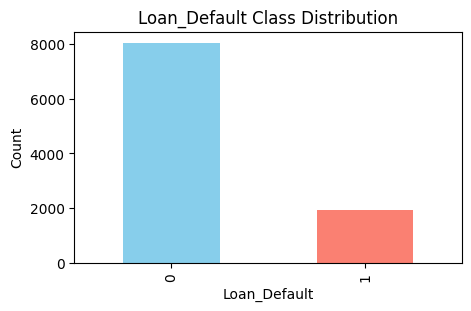

In [23]:
plt.figure(figsize=(5,3))
df[target_col].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title(f"{target_col} Class Distribution")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.show()

In [ ]:
# Split Data per Client

In [24]:
feature_cols = [col for col in df.columns if col not in ['client_id', target_col]]
label_col = target_col

In [25]:
client_ids = df['client_id'].unique()
client_train_data, client_test_data = {}, {}

In [26]:
for cid in client_ids:
    df_c = df[df.client_id == cid]
    X = df_c[feature_cols].values.astype(np.float32)
    y = df_c[label_col].values.astype(np.int32)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    client_train_data[cid] = (X_train, y_train)
    client_test_data[cid] = (X_test, y_test)

In [ ]:
# Define Neural Network

In [27]:
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Federated Learning Client

In [28]:
class FederatedClient(fl.client.NumPyClient):
    def __init__(self, cid):
        self.client_label = cid
        self.model = build_model(input_shape=(len(feature_cols),))
        self.X_train, self.y_train = client_train_data[cid]
        self.X_test, self.y_test = client_test_data[cid]

In [29]:
def get_parameters(self):
        return self.model.get_weights()

In [30]:
def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=1, batch_size=16, verbose=0)
        return self.model.get_weights(), len(self.X_train), {}

In [ ]:
def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        return loss, len(self.X_test), {"accuracy": acc}

In [31]:
# Run Federated Simulation

In [32]:
strategy = fl.server.strategy.FedAvg()

In [38]:
from flwr.common import Context

# Create a mapping from simulation client IDs to dataset client IDs
client_id_map = {f"client_{i}": cid for i, cid in enumerate(client_ids)}

history = fl.simulation.start_simulation(
    client_fn=lambda context: FederatedClient(client_id_map[context.args.cid]),
    num_clients=len(client_ids),
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-07-22 11:19:26,080	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3982006272.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7964012544.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_c

RuntimeError: Simulation crashed.

In [ ]:
# Global Accuracy Plot

In [ ]:
rounds = list(range(1, len(history["test_accuracy"]) + 1))
plt.plot(rounds, history["test_accuracy"], marker="o")
plt.title("Global Model Test Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(rounds)
plt.grid(True)
plt.show()

In [ ]:
# Classification Report & Confusion Matrix

In [ ]:
global_model = build_model(input_shape=(len(feature_cols),))
global_model.set_weights(final_weights)

In [ ]:
y_true, y_pred = [], []

In [ ]:
for cid in client_ids:
    X_test, y_test = client_test_data[cid]
    preds = (global_model.predict(X_test) > 0.5).astype(int).flatten()
    y_true.extend(y_test.tolist())
    y_pred.extend(preds.tolist())

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()